In [1]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import matplotlib.patches as patches

from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mannwhitneyu, sem
from scipy.optimize import curve_fit, minimize
from scipy.io import loadmat
from scipy.linalg import null_space
from scipy.spatial.distance import cdist

import seaborn as sns
from copy import deepcopy as dc
from statsmodels.stats.multitest import multipletests
import math
from itertools import combinations, product

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

from umap import UMAP

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 변수 loading

# openscope
with open('SVM_prerequisite_variables.pickle', 'rb') as f:
    SVM_prerequisite_variables = pickle.load(f)
    
    list_rate_w1 = SVM_prerequisite_variables['list_rate_w1'].copy()
    list_stm_w1 = SVM_prerequisite_variables['list_stm_w1'].copy()
    list_neu_loc = SVM_prerequisite_variables['list_neu_loc'].copy()
    list_wfdur = SVM_prerequisite_variables['list_wfdur'].copy()
    list_slopes_an_loglog = SVM_prerequisite_variables['list_slopes_an_loglog'].copy()
    list_slopes_an_loglog_12 = SVM_prerequisite_variables['list_slopes_an_loglog_12'].copy()

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()

In [4]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1)
        trial_var = np.var(trial_rate, axis=1, ddof=1)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [6]:
# cosine similarity 계산 함수
def cos_sim(x, y):
    # x, y 각각 1d vector

    # dot_xy = np.dot(x, y)
    # norm_x, norm_y = np.linalg.norm(x), np.linalg.norm(y)

    # cos_sim = dot_xy / (norm_x * norm_y)

    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [7]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; floating point 문제 때문에 아주 작은 값 더함
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

In [8]:
# eigenvalue 계산 함수

# ISOMAP
def compute_eigenvalues_isomap(rate, isomap):
    n_samples = rate.shape[1]
    H = np.eye(n_samples) - np.ones((n_samples, n_samples)) / n_samples # centering matrix
    kernel_matrix = -0.5 * H @ (isomap.dist_matrix_ ** 2) @ H
    eigenvalues, _ = np.linalg.eigh(kernel_matrix)
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]

    return eigenvalues_sorted

# PCA
def compute_eigenvalues_pca(rate):
    eigenvalues, _ = np.linalg.eigh(np.cov(rate))
    eigenvalues_sorted = np.sort(eigenvalues)[::-1]
    
    return eigenvalues_sorted

wcfg1 Ic, Lc, Tre isomap (RRneuron)

session index: 6


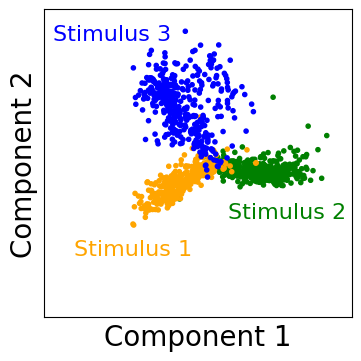

target_slope = 0.0


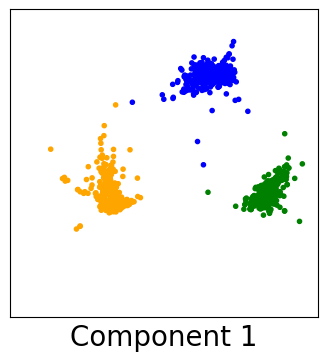

target_slope = 1.0


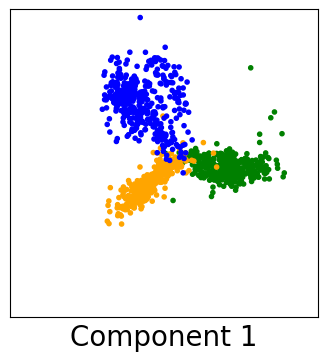

target_slope = 2.0


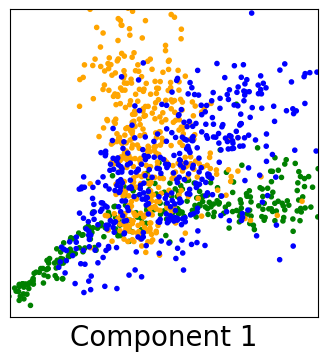

In [9]:
# wcfg1 Ic, Lc, Tre isomap (RRneuron) (figure용)
    
print(f'wcfg1 Ic, Lc, Tre isomap (RRneuron)\n')

num_trial_types = 12
num_trials = 400 # Ic, Tre는 repeat 400번
list_target_slopes = [0, 1, 2]

# 모든 session에 대해 iteration

for sess_ind, (rate_all, stm, neu_loc, wfdur) in enumerate(zip(list_rate_w1, list_stm_w1, list_neu_loc, list_wfdur)):
    
    if sess_ind == 6:
    
        print(f'session index: {sess_ind}')

        # rate_all transposition
        rate_all = rate_all.T.copy()

        # V1 neuron만 추출 + RS cell만 추출
        ser_neu_loc = pd.Series(neu_loc)
        list_visp = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm')]
        rate = rate_all[[all(bools) for bools in zip(*list_visp)]].copy()
        # print(rate.shape[0])
        # list_visp_rs = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm'), (wfdur >= 0.4)]
        # rate = rate_all[[all(bools) for bools in zip(*list_visp_rs)]].copy()
        # print(np.sum([all(bools) for bools in zip(*list_visp_rs)]))

        # delta t 곱해서 spike count로 만들기
        rate = rate * 0.4
        
        # stm type별 counting & string name dictionary 제작
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) # 모든 trial type counting
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
        dict_trial_type = {0: 'Blank', 1: 'X', 2:'Tc1', 3: 'Ic1', 4: 'Lc1', 5:'Tc2', 6: 'Lc2', 7: 'Ic2', \
            8: 'Ire1', 9: 'Ire2', 10: 'Tre1', 11: 'Tre2', 12: 'Xre1', 13: 'Xre2', 14: 'BR_in', 15: 'BL_in', \
                16: 'TL_in', 17: 'TR_in', 18: 'BR_out', 19: 'BL_out', 20: 'TL_out', 21: 'TR_out'}
        
        # 모든 trial type (총 22가지)에 대해 label array 생성
        label = []
        for i in stm:
            for trial_type_num in dict_trial_type:
                if i == trial_type_num:
                    label.append(dict_trial_type[trial_type_num])
        label = np.array(label)

        # rate dataframe화 (columns 지정)
        rate = pd.DataFrame(rate, columns=label)

        # rate/label에서 trial type끼리 모아놓기
        rate_sorted = rate.sort_index(axis=1)
        label_sorted = np.array(sorted(label))

        # label type별 counting & string name dictionary 제작
        all_label_unique, all_label_counts = np.unique(label, return_counts=True) # 모든 trial type counting
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # trial 400번인 trial type만 추출
        rate_sorted = rate_sorted.loc[:, all_label_unique[all_label_counts == 400]].copy()
        all_label_unique, all_label_counts = np.unique(rate_sorted.columns, return_counts=True) # 모든 trial type counting
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # trial type별로 rate의 평균/분산 기록 & 분산 0이 하나라도 있는 뉴런 제거
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(label_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted)

        list_slopes_dr = pd.DataFrame(list_slopes_an_loglog_12[sess_ind], \
                                    columns=rate_sorted_mean_coll.columns).copy()

        # isomap
        n_components = 2 # 목표 차원 수
        # n_components = rate_sorted.shape[0] # 목표 차원 수
        n_neighbors = 5 # 이웃 점 개수

        isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
        
        rate_isomap = pd.DataFrame(isomap.fit_transform(rate_sorted.T).T, columns=rate_sorted.columns)
        rate_1_isomap = rate_isomap.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
        rate_2_isomap = rate_isomap.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
        rate_12_isomap = rate_isomap.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

        # # figure, axes 준비
        # fig, axes = plt.subplots(2, len(list_target_slopes)+1, figsize=(16, 8)) # as-is도 그려야 되니까 +1

        # color list & label list
        list_colors = ['green', 'orange', 'blue']
        list_colors_12 = ['greenyellow', 'forestgreen', 'sandybrown', 'orangered', 'dodgerblue', 'royalblue']
        list_colors_all = [list_colors, list_colors, list_colors_12, list_colors, list_colors, list_colors_12]

        list_labels_1 = ['Ic1', 'Lc1', 'Tre1']
        list_labels_2 = ['Ic2', 'Lc2', 'Tre2']
        list_labels_12 = ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']
        list_labels_all = [list_labels_1, list_labels_2, list_labels_12, list_labels_1, list_labels_2, list_labels_12]
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.scatter(rate_1_isomap.iloc[0], rate_1_isomap.iloc[1], marker='.', \
                c=np.repeat(list_colors_all[0], num_trials))

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        ax.set_xlim([-160, 160])
        ax.set_ylim([-160, 160])
        ax.set_aspect('equal')
        ax.set_xticks([]) # tick, label 지우기
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        ax.annotate(f'Stimulus 1', xy=(0.1, 0.2), xycoords='axes fraction', fontsize=16, color='orange')
        ax.annotate(f'Stimulus 2', xy=(0.6, 0.32), xycoords='axes fraction', fontsize=16, color='green')
        ax.annotate(f'Stimulus 3', xy=(0.03, 0.9), xycoords='axes fraction', fontsize=16, color='blue')

        plt.show()
        
        list_rate_RRneuron = np.empty(len(list_target_slopes), dtype=object)
        list_rate_RRneuron_isomap = np.zeros((len(list_target_slopes), 2, *rate_1_isomap.shape))
        list_params_est = np.full((len(list_target_slopes), num_trial_types, rate_sorted.shape[0], 2), np.nan) # parameter 2개
        for slope_ind, target_slope in enumerate(list_target_slopes):

            # 평균이 0인 경우 NaN으로 바꾸기 (mean이 0인 경우와 var이 0인 경우가 정확히 일치하는 것을 이미 확인함.)
            rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
            rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan
            
            print(f'target_slope = {target_slope:.1f}')

            # RRneuron var 계산
            var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                    columns=rate_sorted_var_coll.columns) # RRneuron0 var (collapsed)
            for trial_type in rate_sorted_var_coll.columns:
                var_estim_dr.loc[:, trial_type] = \
                    np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
            # var_estim_dr = np.repeat(var_estim_dr, all_label_counts, axis=1) # RRneuron0가 아니면 필요 없음
            # print(var_estim_dr)

            # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
            # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed # 산술평균 유지
            offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.log10(rate_sorted_mean_coll).mean(axis=0) + list_slopes_dr.iloc[1, :]) # 기하평균 유지, dataframe.mean()은 default로 skipna=True

            var_rs_noisy = \
                pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                    .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # broadcasting하려면 Series이거나 ndarray여야 함 # collapsed
            var_rs_noisy = np.repeat(var_rs_noisy.values, all_label_counts, axis=1)

            # rate residual RR 계산 & mean과 다시 합하기            
            rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
            # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
            #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
            rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                .mul(np.sqrt(var_rs_noisy))
            # print(rate_resid_RRneuron_dr)
            rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
            rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # NaN을 다시 0으로 바꾸기!        

            # FF 출력해서 의도대로 됐는지 확인
            rate_mean_RRneuron_dr, rate_var_RRneuron_dr = \
                compute_mean_var_trial_collapse(label_cnt_dict, rate_RRneuron_dr)
            # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
            # print(FF_RRneuron)
            # print(rate_var_RRneuron_dr)
            list_rate_RRneuron[slope_ind] = rate_RRneuron_dr.copy()
                        
            # Ic & Tre 추출 & z-scoring
            rate_1_RRneuron = rate_RRneuron_dr.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
            rate_2_RRneuron = rate_RRneuron_dr.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
            rate_12_RRneuron = rate_RRneuron_dr.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

            # isomap (RRneuron)
            rate_RRneuron_isomap = pd.DataFrame(isomap.fit_transform(rate_RRneuron_dr.T).T, columns=rate_RRneuron_dr.columns) # RRneuron 자체 축 찾기
            rate_1_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic1', 'Lc1', 'Tre1']].copy()
            rate_2_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic2', 'Lc2', 'Tre2']].copy()
            rate_12_RRneuron_isomap = rate_RRneuron_isomap.loc[:, ['Ic1', 'Ic2', 'Lc1', 'Lc2', 'Tre1', 'Tre2']].copy()

            list_rate_RRneuron_isomap[slope_ind] = [rate_1_RRneuron_isomap, rate_2_RRneuron_isomap].copy()
            
            # 2D scatterplot
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.scatter(rate_1_RRneuron_isomap.iloc[0], rate_1_RRneuron_isomap.iloc[1], marker='.', \
                    c=np.repeat(list_colors_all[0], num_trials))

            # ax.set_title('as-is', fontsize=20)
            ax.tick_params('both', labelsize=18)
            
            ax.set_xlim([-160, 160])
            ax.set_ylim([-160, 160])
            ax.set_aspect('equal')
            ax.set_xticks([]) # tick, label 지우기
            ax.set_yticks([])
            ax.set_xlabel('Component 1', fontsize=20)
            # ax.set_ylabel('Component 2', fontsize=20)

            plt.show()

session index: 14


c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[93, 8, 62]


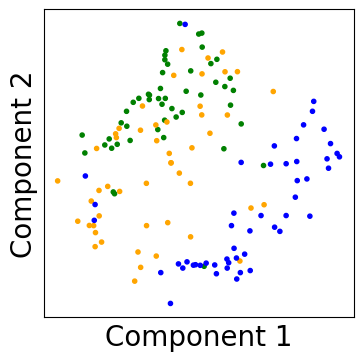

target_slope = 0.0


c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


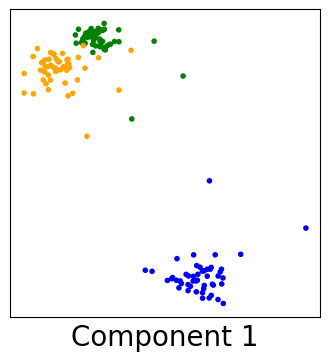

target_slope = 1.0


c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


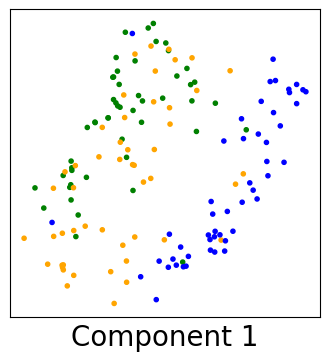

target_slope = 2.0


c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


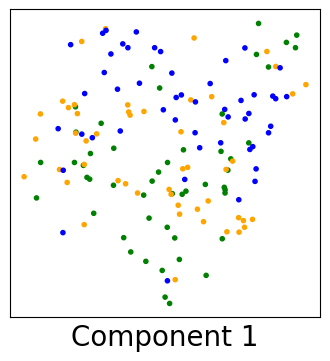

In [10]:
# natural scenes umap (RRneuron) (figure용, trial type trio)
    
list_target_slopes_short = [0, 1, 2]

num_sess = 32
num_trials = 50

# 모든 session에 대해 iteration

# list_dims = np.zeros((num_sess, len(list_target_slopes_short)+1))
for sess_ind, rate in enumerate(list_rate_all):
    if sess_ind == 14:
        print(f'session index: {sess_ind}')
        
        rate_sorted = rate.sort_index(axis=1)
        stm = rate_sorted.columns.copy()

        # delta t 곱해서 spike count로 만들기
        rate_sorted = rate_sorted * 0.25

        # stm type별 counting dictionary 제작
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) # 모든 trial type counting
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

        # trial type별 mean & variance 계산
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

        list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
                                    columns=rate_sorted_mean_coll.columns).copy()

        # umap
        n_components = 2 # 목표 차원 수
        n_neighbors = int(rate_sorted.shape[1] / 90) # 이웃 점 개수
        min_dist = 0.4
        random_state = 5

        umap = UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist)
        target = np.array(stm).copy()
        target[np.random.choice(rate_sorted.shape[1], size=int(0.5*rate_sorted.shape[1]), replace=False)] = -1
        
        rate_umap = pd.DataFrame(umap.fit_transform(rate_sorted.T, y=target).T, columns=rate_sorted.columns) # supervision 선택
        # rate_trio_umap = rate_umap.loc[:, adj_tt_trio].copy()
        # rand_tt_trio = np.random.choice(all_stm_unique, 3, replace=False)
        rand_tt_trio = [93, 8, 62]
        print(rand_tt_trio)
        rate_trio_umap = rate_umap.loc[:, rand_tt_trio].copy()

        # figure, axes 준비
        # fig, axes = plt.subplots(1, len(list_target_slopes_short)+1, figsize=(12, 4)) # as-is도 그려야 되니까 +1

        # color list & label list
        list_colors = ['green', 'orange', 'blue']
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.scatter(rate_trio_umap.iloc[0], rate_trio_umap.iloc[1], marker='.', \
                c=np.repeat(list_colors, num_trials))

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        # ax.set_aspect('equal')
        ax.set_xticks([]) # tick, label 지우기
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        plt.show()

        # 평균이 0인 경우 NaN으로 바꾸기 (mean이 0인 경우와 var이 0인 경우가 정확히 일치하는 것을 이미 확인함.)
        rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
        rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan
        
        list_rate_RRneuron_umap = np.zeros((len(list_target_slopes_short), *rate_trio_umap.shape))
        for slope_ind, target_slope in enumerate(list_target_slopes_short):
            print(f'target_slope = {target_slope:.1f}')

            # RRneuron var 계산
            var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
                                    columns=rate_sorted_var_coll.columns) # RRneuron0 var (collapsed)
            for trial_type in rate_sorted_var_coll.columns:
                var_estim_dr.loc[:, trial_type] = \
                    np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
            # var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) # RRneuron0가 아니면 필요 없음
            # print(var_estim_dr)

            # offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
            # .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed # 산술평균 유지
            offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.log10(rate_sorted_mean_coll).mean(axis=0) + list_slopes_dr.iloc[1, :]) # 기하평균 유지, dataframe.mean()은 default로 skipna=True

            var_rs_noisy = \
                pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
                    .div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # broadcasting하려면 Series이거나 ndarray여야 함 # collapsed
            var_rs_noisy = np.repeat(var_rs_noisy.values, all_stm_counts, axis=1)

            # rate residual RR 계산 & mean과 다시 합하기            
            rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
            # rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
            #     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
            rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
                .mul(np.sqrt(var_rs_noisy))
            # print(rate_resid_RRneuron_dr)
            rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
            rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # NaN을 다시 0으로 바꾸기!        

            # FF 출력해서 의도대로 됐는지 확인
            rate_mean_RRneuron_dr, rate_var_RRneuron_dr = \
                compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
            # FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
            # print(FF_RRneuron)
            # print(rate_var_RRneuron_dr)

            # RR 자체 umap
            rate_RRneuron_umap = pd.DataFrame(umap.fit_transform(rate_RRneuron_dr.T, y=target).T, columns=rate_RRneuron_dr.columns)
            # rate_trio_RRneuron_umap = rate_RRneuron_umap.loc[:, adj_tt_trio].copy()
            rate_trio_RRneuron_umap = rate_RRneuron_umap.loc[:, rand_tt_trio].copy()

            list_rate_RRneuron_umap[slope_ind] = rate_trio_RRneuron_umap.copy()
            
            # 2D scatterplot
            fig, ax = plt.subplots(1, 1, figsize=(4, 4))
            # ax.axhline(0, c='0.7') # x축
            # ax.axvline(0, c='0.7') # y축
            ax.scatter(rate_trio_RRneuron_umap.iloc[0], rate_trio_RRneuron_umap.iloc[1], marker='.', \
                    c=np.repeat(list_colors, num_trials))

            # ax.set_title(f'Slope {target_slope}', fontsize=20)
            ax.tick_params('both', labelsize=18)

            # ax.set_aspect('equal')
            ax.set_xticks([]) # tick, label 지우기
            ax.set_yticks([])
            ax.set_xlabel('Component 1', fontsize=20)
            # ax.set_ylabel('Component 2', fontsize=20)

            plt.show()

In [ ]:
# ABO pairwise & population-wise noise correlation (RRneuron) (session당 ~20 sec)

list_target_slopes = [0, 1, 2] # 목표로 하는 RRneuron 기울기

num_sess = 32
n_pairs = 100 # pairwise correlation을 구할 neuron pair 수
num_trial_types = 119

# 모든 session에 대해 iteration

list_pair_nc_RRneuron2 = np.zeros((num_sess, n_pairs, len(list_target_slopes)+1, num_trial_types))
list_pc1_eig_asis2 = np.zeros((num_sess, num_trial_types))
list_pc1_eig_RRneuron3 = np.zeros((num_sess, len(list_target_slopes), num_trial_types))

for sess_ind, rate in enumerate(list_rate_all):
	if sess_ind == 7:
		print(f'session index: {sess_ind}')
		
		rate_sorted = rate.sort_index(axis=1)
		stm = rate_sorted.columns.copy()

		# delta t 곱해서 spike count로 만들기
		rate_sorted = rate_sorted * 0.25

		# stm type별 counting dictionary 제작
		all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) # 모든 trial type counting
		stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))

		# trial type별 mean & variance 계산
		rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(stm_cnt_dict, rate_sorted)
		rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(stm_cnt_dict, rate_sorted)

		list_slopes_dr = pd.DataFrame(list_slopes_all_an_loglog[sess_ind], \
									columns=rate_sorted_mean_coll.columns).copy()
		
		# pca 준비
		n_components = 1
		pca = PCA(n_components=n_components)

		# 각 trial type별로 PC1의 explained variance ratio 저장
		list_pc1_eig_asis = np.zeros(rate_sorted_mean_coll.shape[1])
		for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
			rate_tt = rate_sorted.loc[:, trial_type].copy()
			rate_tt_pca = pca.fit_transform(rate_tt.T).T
			list_pc1_eig_asis[trial_type_ind] = pca.explained_variance_ratio_[0]

		list_pc1_eig_asis2[sess_ind] = list_pc1_eig_asis.copy()

		list_rate_RRneuron = np.empty(len(list_target_slopes), dtype=object)
		list_pc1_eig_RRneuron2 = np.zeros((len(list_target_slopes), rate_sorted_mean_coll.shape[1]))
		for slope_ind, target_slope in enumerate(list_target_slopes):
			
			# 평균이 0인 경우 NaN으로 바꾸기 (mean이 0인 경우와 var이 0인 경우가 정확히 일치하는 것을 이미 확인함.)
			rate_sorted_mean_coll[rate_sorted_mean_coll == 0] = np.nan
			rate_sorted_var_coll[rate_sorted_var_coll == 0] = np.nan

			print(f'target_slope = {target_slope:.1f}')

			# RRneuron

			# RRneuron var 계산
			var_estim_dr = pd.DataFrame(np.zeros((1, rate_sorted_var_coll.shape[1])), \
									columns=rate_sorted_var_coll.columns) # RRneuron0 var (collapsed)
			for trial_type in rate_sorted_var_coll.columns:
				var_estim_dr.loc[:, trial_type] = \
					np.nanmean(rate_sorted_var.loc[:, trial_type].values.flatten()) # nanmean
			# var_estim_dr = np.repeat(var_estim_dr, all_stm_counts, axis=1) # RRneuron0가 아니면 필요 없음
			# print(var_estim_dr)

			# offset = var_estim_dr.div(rate_sorted_var_coll.pow(target_slope/list_slopes_dr.iloc[0, :], axis=1).mean(axis=0))\
			# .mul(pow(10, target_slope * list_slopes_dr.iloc[1, :] / list_slopes_dr.iloc[0, :])) # collapsed # 산술평균 유지
			offset = pow(10, (list_slopes_dr.iloc[0, :]-target_slope) * np.nanmean(np.log10(rate_sorted_mean_coll), axis=0) + list_slopes_dr.iloc[1, :]) # 기하평균 유지, dataframe.mean()은 default로 skipna=True

			var_rs_noisy = \
				pow(10, np.log10(rate_sorted_var_coll).sub(list_slopes_dr.iloc[1, :], axis=1)\
					.div(list_slopes_dr.iloc[0, :], axis=1).mul(target_slope).add(np.log10(np.array(offset)), axis=1)) # broadcasting하려면 Series이거나 ndarray여야 함 # collapsed
			var_rs_noisy = np.repeat(np.array(var_rs_noisy), all_stm_counts, axis=1) # numpy 버전 이슈로 ndarray로 바꿔줘야 함

			# rate residual RR 계산 & mean과 다시 합하기            
			rate_sorted_resid_dr = rate_sorted - rate_sorted_mean
			# rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
			#     .mul(np.sqrt(rate_sorted_mean)).mul(np.sqrt(FF_estim_dr), axis=1)
			rate_resid_RRneuron_dr = rate_sorted_resid_dr.div(np.sqrt(rate_sorted_var))\
			    .mul(np.sqrt(var_rs_noisy))
			# print(rate_resid_RRneuron_dr)
			rate_RRneuron_dr = rate_sorted_mean + rate_resid_RRneuron_dr
			rate_RRneuron_dr[rate_RRneuron_dr.isna()] = 0 # NaN을 다시 0으로 바꾸기!    

			# FF 출력해서 의도대로 됐는지 확인
			rate_mean_RRneuron_coll, rate_var_RRneuron_coll = \
			    compute_mean_var_trial_collapse(stm_cnt_dict, rate_RRneuron_dr)
			# FF_RRneuron = rate_var_RRneuron_dr.div(rate_mean_RRneuron_dr)
			# print(FF_RRneuron)
			# print(rate_var_RRneuron_dr)

			list_rate_RRneuron[slope_ind] = rate_RRneuron_dr.copy()
													
			# 각 trial type별로 PC1의 explained variance ratio 저장
			list_pc1_eig_RRneuron = np.zeros(rate_sorted_mean_coll.shape[1])
			for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
				rate_tt = rate_RRneuron_dr.loc[:, trial_type].copy()
				try:
					rate_tt_pca = pca.fit_transform(rate_tt.T).T
					list_pc1_eig_RRneuron[trial_type_ind] = pca.explained_variance_ratio_[0]
				except:
					list_pc1_eig_RRneuron[trial_type_ind] = np.nan
			
			list_pc1_eig_RRneuron2[slope_ind] = list_pc1_eig_RRneuron.copy()

		list_pc1_eig_RRneuron3[sess_ind] = list_pc1_eig_RRneuron2.copy()

		# pairwise noise correlation

		# random neuron pair에 대해 iteration
		list_pair_nc_RRneuron = np.full((n_pairs, len(list_target_slopes)+1, num_trial_types), np.nan) # as-is, RRneuron
		np.random.seed(sess_ind)
		for pair_ind in range(n_pairs):
			neu_pair = np.random.choice(rate_sorted.index, 2, replace=False)

			# stimulus type별 noise correlation 수집
			pair_nc_RRneuron = np.full((len(list_target_slopes)+1, num_trial_types), np.nan) 
			for trial_type_ind, trial_type in enumerate(rate_sorted_mean_coll.columns):
				
				# as-is
				pair_nc_RRneuron[-1, trial_type_ind] = np.corrcoef(rate_sorted.loc[neu_pair[0], trial_type], rate_sorted.loc[neu_pair[1], trial_type])[0, 1]
				
				# RRneuron
				for slope_ind, target_slope in enumerate(list_target_slopes):
					bool_notnan = np.logical_and(~np.isnan(list_rate_RRneuron[slope_ind].loc[neu_pair[0], trial_type]), ~np.isnan(list_rate_RRneuron[slope_ind].loc[neu_pair[1], trial_type]))
					pair_nc_RRneuron[slope_ind, trial_type_ind] = np.corrcoef(list_rate_RRneuron[slope_ind].loc[neu_pair[0], trial_type].loc[bool_notnan],
															   list_rate_RRneuron[slope_ind].loc[neu_pair[1], trial_type].loc[bool_notnan])[0, 1]
			list_pair_nc_RRneuron[pair_ind] = pair_nc_RRneuron.copy()
		
		list_pair_nc_RRneuron2[sess_ind] = list_pair_nc_RRneuron.copy()

session index: 7
target_slope = 0.0
target_slope = 1.0
target_slope = 2.0


c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\anaconda3\envs\allensdk_ep\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


7
21


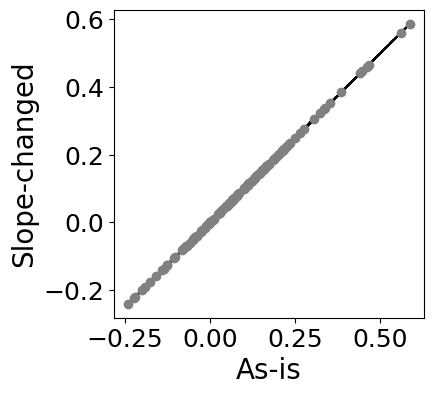

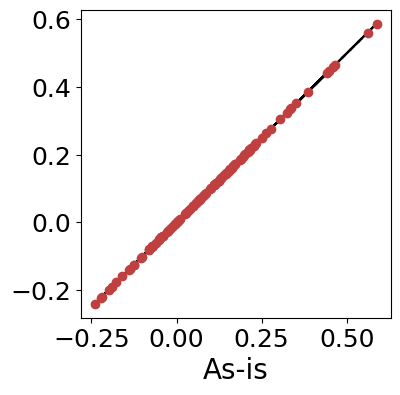

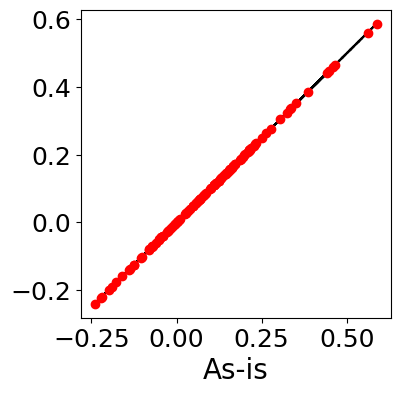

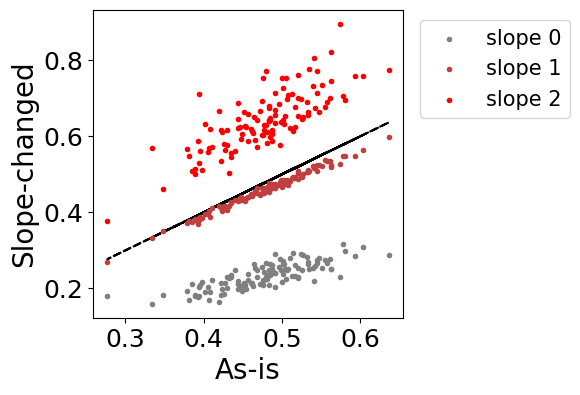

In [13]:
list_target_slopes = [0, 1, 2]
num_sess = 32
n_pairs = 100

# pairwise noise correlation scatterplot (as-is vs. RRneuron)

# Define a custom colormap from gray to red
gray_to_red = mcolors.LinearSegmentedColormap.from_list("gray_to_red", ["gray", "red"])

num_lines = 3 # plotting할 slope 개수
norm = mcolors.Normalize(vmin=0, vmax=num_lines-1)

# scatterplot
sess_ind = np.random.choice(range(num_sess), 1)[0]
sess_ind = 7
print(sess_ind)

pair_ind = np.random.choice(range(n_pairs), 1)[0]
print(pair_ind)

for slope_ind, target_slope in enumerate(list_target_slopes):
	fig, axes = plt.subplots(figsize=(4, 4))
	axes = np.array(axes).flatten()

	axes[0].scatter(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1], list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind],
					marker='o', color=gray_to_red(norm(slope_ind)), label=f'slope {target_slope:.1f}', zorder=2)
	
	# correlation between as-is and RRneuron
	bool_notnan = np.logical_and(~np.isnan(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1]), ~np.isnan(list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind]))
	corr = np.corrcoef(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1][bool_notnan], list_pair_nc_RRneuron2[sess_ind, pair_ind, slope_ind][bool_notnan])[0, 1]

	# y=x line
	axes[0].plot(list_pair_nc_RRneuron2[sess_ind, pair_ind, -1], list_pair_nc_RRneuron2[sess_ind, pair_ind, -1],
				 color='k', linestyle='--', zorder=1)

	# min_, max_ = np.nanmin(list_pair_nc_RRneuron2[sess_ind, pair_ind]), np.nanmax(list_pair_nc_RRneuron2[sess_ind, pair_ind])
	# axes[0].set_xlim(min_, max_)
	# axes[0].set_ylim(min_, max_)

	axes[0].set_xlabel('As-is', fontsize=20)
	if slope_ind == 0:
		axes[0].set_ylabel(f'Slope-changed', fontsize=20)
	axes[0].tick_params('both', labelsize=18)
	# axes[0].annotate(f'r = {corr:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=18)

	# axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 12})

	plt.show()

# popwise noise correlation (PC1 explained variance ratio) scatterplot (as-is vs. RRneuron)

fig, axes = plt.subplots(figsize=(4, 4))
axes = np.array(axes).flatten()

# scatterplot
for slope_ind, target_slope in enumerate(list_target_slopes):
	axes[0].scatter(list_pc1_eig_asis2[sess_ind], list_pc1_eig_RRneuron3[sess_ind, slope_ind],
					marker='.', color=gray_to_red(norm(slope_ind)), label=f'slope {target_slope:.0f}', zorder=2)

# y=x line
axes[0].plot(list_pc1_eig_asis2[sess_ind], list_pc1_eig_asis2[sess_ind],
			 color='k', linestyle='--', zorder=1)

axes[0].set_xlabel('As-is', fontsize=20)
axes[0].set_ylabel('Slope-changed', fontsize=20)
axes[0].tick_params('both', labelsize=18)

axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), prop={'size': 15})

plt.show()